<a href="https://colab.research.google.com/github/copev313/Book-Recommendation-System-Collaborative-Filtering-Using-kNN/blob/main/book-recommendations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building a Book Recommendation System with Machine Learning

In this project we will create a Machine Learning model to be used in a book recommendation system. 

## Introduction

We'll begin by importing our libraries and loading our data into a `pandas` DataFrame.

In [99]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [100]:
# Additional Configuration
pd.set_option('display.max_columns', None)
%matplotlib inline

In [101]:

# Load our book data:
book_data = pd.read_csv('BX-Books.csv',
                        sep=';',
                        error_bad_lines=False,
                        encoding='latin-1')
book_data.columns = ['ISBN', 'bookTitle', 'bookAuthor', 'yearOfPublication',
                     'publisher', 'imageUrlS', 'imageUrlM', 'imageUrlL']

print(book_data.head())


b'Skipping line 6452: expected 8 fields, saw 9\nSkipping line 43667: expected 8 fields, saw 10\nSkipping line 51751: expected 8 fields, saw 9\n'
b'Skipping line 92038: expected 8 fields, saw 9\nSkipping line 104319: expected 8 fields, saw 9\nSkipping line 121768: expected 8 fields, saw 9\n'
b'Skipping line 144058: expected 8 fields, saw 9\nSkipping line 150789: expected 8 fields, saw 9\nSkipping line 157128: expected 8 fields, saw 9\nSkipping line 180189: expected 8 fields, saw 9\nSkipping line 185738: expected 8 fields, saw 9\n'
b'Skipping line 209388: expected 8 fields, saw 9\nSkipping line 220626: expected 8 fields, saw 9\nSkipping line 227933: expected 8 fields, saw 11\nSkipping line 228957: expected 8 fields, saw 10\nSkipping line 245933: expected 8 fields, saw 9\nSkipping line 251296: expected 8 fields, saw 9\nSkipping line 259941: expected 8 fields, saw 9\nSkipping line 261529: expected 8 fields, saw 9\n'


         ISBN                                          bookTitle  \
0  0195153448                                Classical Mythology   
1  0002005018                                       Clara Callan   
2  0060973129                               Decision in Normandy   
3  0374157065  Flu: The Story of the Great Influenza Pandemic...   
4  0393045218                             The Mummies of Urumchi   

             bookAuthor yearOfPublication                   publisher  \
0    Mark P. O. Morford              2002     Oxford University Press   
1  Richard Bruce Wright              2001       HarperFlamingo Canada   
2          Carlo D'Este              1991             HarperPerennial   
3      Gina Bari Kolata              1999        Farrar Straus Giroux   
4       E. J. W. Barber              1999  W. W. Norton &amp; Company   

                                           imageUrlS  \
0  http://images.amazon.com/images/P/0195153448.0...   
1  http://images.amazon.com/images/P/000

In [102]:
# Load our user data:
user_data = pd.read_csv('BX-Users.csv',
                        sep=';',
                        error_bad_lines=False,
                        encoding='latin-1')
user_data.columns = ['userID', 'Location', 'Age']

print(user_data.head())


   userID                            Location    Age
0       1                  nyc, new york, usa    nan
1       2           stockton, california, usa 18.000
2       3     moscow, yukon territory, russia    nan
3       4           porto, v.n.gaia, portugal 17.000
4       5  farnborough, hants, united kingdom    nan


In [103]:
# Load our ratings data:
ratings_data = pd.read_csv('BX-Book-Ratings.csv',
                        sep=';',
                        error_bad_lines=False,
                        encoding='latin-1')
ratings_data.columns = ['userID', 'ISBN', 'bookRating']

print(ratings_data.head())

   userID        ISBN  bookRating
0  276725  034545104X           0
1  276726  0155061224           5
2  276727  0446520802           0
3  276729  052165615X           3
4  276729  0521795028           6


In [104]:
print(ratings_data.shape)
print(list(ratings_data.columns))

(1149780, 3)
['userID', 'ISBN', 'bookRating']


---

Let's look at the distribution of the book ratings.


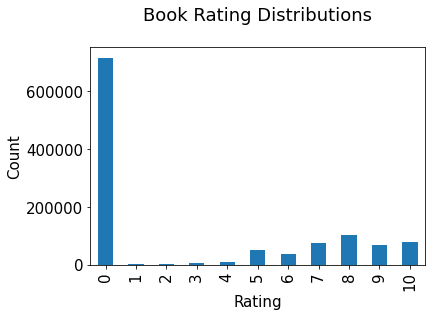

In [105]:
plt.rc('font', size=15)
ratings_data['bookRating'].value_counts(sort=False).plot(kind='bar')

plt.title('Book Rating Distributions\n')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

In [106]:
print(book_data.shape)
print(list(book_data.columns))

(271360, 8)
['ISBN', 'bookTitle', 'bookAuthor', 'yearOfPublication', 'publisher', 'imageUrlS', 'imageUrlM', 'imageUrlL']


In [107]:
print(user_data.shape)
print(list(user_data.columns))

(278858, 3)
['userID', 'Location', 'Age']


---
Now let's plot the age distribution of the users placing the reviews.

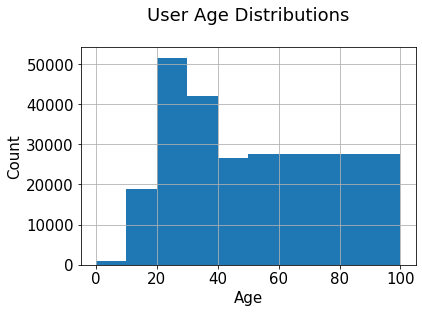

In [108]:
user_data['Age'].hist(bins=[0, 10, 20, 30, 40, 50, 100])
plt.title('User Age Distributions\n')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

---

## Data Refinement

We will remove users with less than 200 ratings, as well as books with less than 100 ratings to ensure statistical significance.

In [109]:
# Get number of ratings for each user:
user_counts = ratings_data['userID'].value_counts()

# Filter ratings data:
ratings_data = ratings_data[ratings_data['userID'].isin(
    user_counts[user_counts >= 200].index
)]


In [110]:
# Get number of ratings for each book:
bk_rating_counts = ratings_data['bookRating'].value_counts()

# Filter ratings data again:
ratings_data = ratings_data[ratings_data['bookRating'].isin(
    bk_rating_counts[bk_rating_counts >= 100].index
)]

---

## Collaborative Filtering Using k-Nearest Neighbors (kNN)

The machine learning algorithm we will be using is called k-Nearest-Neighbors (kNN). This method will find clusters of similar users based on common book ratings. It will make it's predictions by utilizing the mean rating of the top-k nearest neighbors.

First, we will place our ratings into a matrix. This matrix will have one row for reach item, in our case a book, and it will have one column for each user.


In [111]:
# Merge our two DataFrame on the ISBN:
books_ratings_combo = pd.merge(ratings_data, book_data, on='ISBN')

# Create a list of columns to remove:
columns = ['yearOfPublication', 'publisher', 'bookAuthor',
           'imageUrlS', 'imageUrlM', 'imageUrlL']

# Remove columns from combined DataFrame:
books_ratings_combo = books_ratings_combo.drop(columns, axis=1)

# Take a look:
print(books_ratings_combo.head())


   userID        ISBN  bookRating  \
0  277427  002542730X          10   
1    3363  002542730X           0   
2   11676  002542730X           6   
3   12538  002542730X          10   
4   13552  002542730X           0   

                                           bookTitle  
0  Politically Correct Bedtime Stories: Modern Ta...  
1  Politically Correct Bedtime Stories: Modern Ta...  
2  Politically Correct Bedtime Stories: Modern Ta...  
3  Politically Correct Bedtime Stories: Modern Ta...  
4  Politically Correct Bedtime Stories: Modern Ta...  


---

Time to group the books by title and to create a new column for total rating count.


In [112]:
books_ratings_combo = books_ratings_combo.dropna(axis=0, subset=['bookTitle'])

# Group books by title and add the totalRatingCount:
book_rating_count = (books_ratings_combo.groupby(
                      by=['bookTitle'])['bookRating'].count().reset_index()\
                          .rename(
                              columns = {
                                  'bookRating': 'totalRatingCount'
                              })[['bookTitle', 'totalRatingCount']]
                     
)

# Check it out:
print(book_rating_count.head(10))

                                           bookTitle  totalRatingCount
0   A Light in the Storm: The Civil War Diary of ...                 2
1                              Always Have Popsicles                 1
2               Apple Magic (The Collector's series)                 1
3   Beyond IBM: Leadership Marketing and Finance ...                 1
4   Clifford Visita El Hospital (Clifford El Gran...                 1
5                                       Dark Justice                 1
6                                           Deceived                 1
7   Earth Prayers From around the World: 365 Pray...                 3
8   Final Fantasy Anthology: Official Strategy Gu...                 3
9   Flight of Fancy: American Heiresses (Zebra Ba...                 1


---

Now we can combine the ratings data with the total ratings data. This will give us what we need to determine which books are popular, so we can filter out books which aren't know as well.

In [113]:
ratings_total_ratings_combo = books_ratings_combo.merge(
    book_rating_count,
    left_on = 'bookTitle',
    right_on = 'bookTitle',
    how = 'left'
)

print(ratings_total_ratings_combo.head())

   userID        ISBN  bookRating  \
0  277427  002542730X          10   
1    3363  002542730X           0   
2   11676  002542730X           6   
3   12538  002542730X          10   
4   13552  002542730X           0   

                                           bookTitle  totalRatingCount  
0  Politically Correct Bedtime Stories: Modern Ta...                82  
1  Politically Correct Bedtime Stories: Modern Ta...                82  
2  Politically Correct Bedtime Stories: Modern Ta...                82  
3  Politically Correct Bedtime Stories: Modern Ta...                82  
4  Politically Correct Bedtime Stories: Modern Ta...                82  


In [114]:
# Customize our floating point numbers:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

#
print(book_rating_count['totalRatingCount'].describe())

count   160576.000
mean         3.044
std          7.428
min          1.000
25%          1.000
50%          1.000
75%          2.000
max        365.000
Name: totalRatingCount, dtype: float64


In [115]:
print(
    book_rating_count['totalRatingCount'].quantile(
      np.arange(0.9, 1, 0.01)
))

0.900    5.000
0.910    6.000
0.920    7.000
0.930    7.000
0.940    8.000
0.950   10.000
0.960   11.000
0.970   14.000
0.980   19.000
0.990   31.000
Name: totalRatingCount, dtype: float64


In [116]:
popularity_threshold = 50

rating_popular_book = ratings_total_ratings_combo.query(
    "totalRatingCount >= @popularity_threshold"
)

print(rating_popular_book.head())

   userID        ISBN  bookRating  \
0  277427  002542730X          10   
1    3363  002542730X           0   
2   11676  002542730X           6   
3   12538  002542730X          10   
4   13552  002542730X           0   

                                           bookTitle  totalRatingCount  
0  Politically Correct Bedtime Stories: Modern Ta...                82  
1  Politically Correct Bedtime Stories: Modern Ta...                82  
2  Politically Correct Bedtime Stories: Modern Ta...                82  
3  Politically Correct Bedtime Stories: Modern Ta...                82  
4  Politically Correct Bedtime Stories: Modern Ta...                82  


In [117]:
combined = rating_popular_book.merge(
    user_data,
    left_on='userID',
    right_on='userID',
    how='left'
)

# Filter to users in United States and Canada only:
us_canada_user_ratings = combined[
    combined['Location'].str.contains("usa|canada")]

us_canada_user_ratings = us_canada_user_ratings.drop('Age', axis=1)

print(us_canada_user_ratings.head())

   userID        ISBN  bookRating  \
0  277427  002542730X          10   
1    3363  002542730X           0   
3   12538  002542730X          10   
4   13552  002542730X           0   
5   16795  002542730X           0   

                                           bookTitle  totalRatingCount  \
0  Politically Correct Bedtime Stories: Modern Ta...                82   
1  Politically Correct Bedtime Stories: Modern Ta...                82   
3  Politically Correct Bedtime Stories: Modern Ta...                82   
4  Politically Correct Bedtime Stories: Modern Ta...                82   
5  Politically Correct Bedtime Stories: Modern Ta...                82   

                        Location  
0          gilbert, arizona, usa  
1      knoxville, tennessee, usa  
3          byron, minnesota, usa  
4        cordova, tennessee, usa  
5  mechanicsville, maryland, usa  


---

## Implementing kNN

Our next step is to convert our table into a two-dimensional matrix. We will fill missing values with zeros, since we're calculating distances between rating vectors.

Then we can transform the values, in our case ratings, into a scipy sparse matrix to make our calculations more efficient.

In [118]:
from scipy.sparse import csr_matrix


us_canada_user_ratings = us_canada_user_ratings.drop_duplicates(
    ['userID', 'bookTitle']
)

us_ca_user_rating_pivot = us_canada_user_ratings.pivot(
    index='bookTitle',
    columns = 'userID',
    values = 'bookRating'

).fillna(0)


us_ca_user_rating_matix = csr_matrix(us_ca_user_rating_pivot.values)


---

Now we'll use the ratings matrix to fit our data and create our model.

In [119]:
from sklearn.neighbors import NearestNeighbors

# Define + Instantiate model:
knn_model = NearestNeighbors(metric='cosine', algorithm='brute')

# Fit data using ratings matrix:
knn_model.fit(us_ca_user_rating_matix)

# Look at the model properties:
print(knn_model)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)


In [120]:
query_index = np.random.choice(us_ca_user_rating_pivot.shape[0])
print(query_index)

print(
    us_ca_user_rating_pivot.iloc[query_index, : ].values.reshape(1, -1)
)

distances, indices = knn_model.kneighbors(
    us_ca_user_rating_pivot.iloc[query_index, : ].values.reshape(1, -1),
    n_neighbors = 6
)

us_ca_user_rating_pivot.index[query_index]


633
[[ 0.  0.  0.  0.  0.  0.  0.  7.  0.  0.  0.  0.  8.  0.  0.  0. 10.  0.
   9.  8.  0.  0.  0.  0.  0.  0.  9.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  9.  0.  0.  0.  0.  0.  0.  9.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  9.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  8.
   0. 10.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 10.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0. 10.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  7.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 10.  0.  0.  0.  0.  0.  0.
   0. 10.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  8.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  9.  0.  0.  0.  0.  0.  7. 10.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  5.  0.  0. 

'The Red Tent (Bestselling Backlist)'

In [121]:
for i in range(len(distances.flatten())):
  if (i == 0):
    print("Recommendations for {}:\n".format(
        us_ca_user_rating_pivot.index[query_index]
    ))
  
  else:
    print("{i}: {title}, with distance of {dist}".format(
        i=i,
        title=us_ca_user_rating_pivot.index[indices.flatten()[i]],
        dist=distances.flatten()[i]
    ))

Recommendations for The Red Tent (Bestselling Backlist):

1: Girl with a Pearl Earring, with distance of 0.6784425030365467
2: The Reader, with distance of 0.7320545897328294
3: The Clan of the Cave Bear (Earth's Children (Paperback)), with distance of 0.75050688528971
4: The Bonesetter's Daughter, with distance of 0.7525742456087645
5: Divine Secrets of the Ya-Ya Sisterhood: A Novel, with distance of 0.7570153145315475


---
*Special thanks to AMAN KHARWAL for the project idea and guide.*